In [2]:
import pandas as pd
import numpy as np
import functools
from tqdm import tqdm

In [3]:
df = pd.read_csv("eszz_data.csv")

In [4]:
df.columns

Index(['sha', 'num_of_insertions', 'num_of_deletions', 'num_of_changed_files',
       'day_of_week', 'hour_of_commit', 'solve_time', 'resolution_time',
       'solve_res_diff', 'number_of_comments', 'summary', 'description',
       'components', 'affects_versions', 'comments', 'number_of_patches',
       'patch_size_mean', 'patch_size_variance', 'patch_size_rel_variance',
       'filepath_contains_test', 'label'],
      dtype='object')

In [5]:
#df.drop(['summary', 'description', 'comments'], axis=1, inplace=True)
df.drop(['comments'], axis=1, inplace=True)

In [6]:
df.description.replace(np.nan, "", inplace=True)
df.summary.replace(np.nan, "", inplace=True)

In [8]:
import re
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from collections import Counter

In [9]:
def create_regex(rgx, to_sub_string, flag = None):
    if flag != None:
        compiled_rgx = re.compile(rgx, flags = flag)
    else:
        compiled_rgx = re.compile(rgx)
    substitutes.append((compiled_rgx, to_sub_string))

substitutes = []

create_regex(r'[\w\d_\-\.$]+\(.*\)', "METHOD")

create_regex(r'([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))', "DATE")

create_regex(r'(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])(,\d+)?', "TIME")

create_regex(r'(https?|ftp):\/\/[^\s/$.?#].[^\s]*', "URL")

create_regex(r'\[.*?\|?http.*?\]', "URL")

create_regex(r'\s+npe\s+', ' EXCEPTION ', re.IGNORECASE)

create_regex(r'[A-Z]+-\d+', "JIRAID")

create_regex(r'file:\/[^\s\n\t\r]*', "FILEPATH")

create_regex(r'\[.*?file:\\\.*?\]', "FILEPATH")

create_regex(r'\[~.*]', "USERNAME")

create_regex(r'{code:?.*}[\s\S]*?{code}|{noformat}[\s\S]*?{noformat}|{{.*?}}', "CODE", re.MULTILINE)

create_regex(r'\w*Error[^\s\n\t\r]*|\w*error[^\s\n\t\r]*', 'ERROR')

create_regex(r'\w*Exception[^\s\n\t\r]*|\w*exception[^\s\n\t\r]*', 'EXCEPTION')

def apply_rules_to(sentence):
    for substitute in substitutes:
        sentence = substitute[0].sub(substitute[1], sentence)
    return sentence

In [10]:
df.description = df.description.map(apply_rules_to)
df.summary = df.summary.map(apply_rules_to)

In [11]:
def func(groupby, x):
    if isinstance(x, list):
        agg = groupby[x]
        result = (agg[:,"count"] * agg[:,"mean"]).sum() / agg[:,"count"].sum()
        return result
#     print(groupby)
    return groupby[:,"mean"].mean()

def multi_value_target_encoding(df, by_labels, on_label, separator):
    dummy = df.copy()
    results = []
    for by in by_labels:
        dummy[by] = dummy[by].str.split(separator)
        groupby_count_mean = (dummy
           .set_index(on_label)[by]
           .apply(pd.Series)
           .stack()
           .reset_index(name=by)  # Reshape the data
           .groupby([by])
           .label
           .apply(lambda x: x.agg(['count', 'mean'])))
#         print(groupby_count_mean)

        my_func = functools.partial(func, groupby_count_mean)
        res = dummy[by].map(my_func).to_numpy()
        results.append(res)
    return np.vstack(results).T
        

Blamed commits

In [12]:
blamed_shas = set()
with open('blamed_commits.txt', 'r') as f:
    for line in f.readlines():
        blamed_shas.add(line[:-1])

In [14]:
eval_df = df[df['sha'].isin(blamed_shas)]
df = df[~df['sha'].isin(blamed_shas)]

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

In [68]:
numeric_features = ['num_of_insertions', 'num_of_deletions', 'num_of_changed_files', 
                      'day_of_week', 'hour_of_commit', 'solve_time', 'resolution_time', 
                     'solve_res_diff', 'number_of_comments', 'number_of_patches',
                    'patch_size_mean', 'patch_size_variance', 'patch_size_rel_variance', 'filepath_contains_test']
text_features = ['summary', 'description']

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
text_transformer = Pipeline(steps=[
     ('vect', CountVectorizer(tokenizer=wordpunct_tokenize, stop_words=set(stopwords.words('english')),
                             ngram_range=(1,1), max_features=10000)),
    ('tfidf', TfidfTransformer()),
    ('tsvd', TruncatedSVD(n_components=10))
 ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='drop')

categorical_features = ['components', 'affects_versions']
processed_features = numeric_features + categorical_features + 10*['summary'] + 10*['description']

In [69]:
X = df.drop('label', axis=1)
y = df['label']
X_text_summary = text_transformer.fit_transform(df.summary.to_numpy(), y)
X_text_description = text_transformer.fit_transform(df.description.to_numpy(), y)
# preprocess X
X = preprocessor.fit_transform(X, y)
X_categorical = multi_value_target_encoding(df, categorical_features, 'label', ';')
X = np.hstack((X,X_categorical,X_text_summary, X_text_description))

/Users/minaremeli/virtual_envs/venv_CRA/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'"] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## GridSearchCV

Grid Search + Cross-Validation

In [119]:
from collections import Counter

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [57]:
from sklearn.model_selection import GridSearchCV

In [141]:
params = {
          'max_depth': [2, 3, 4, 5],
          'learning_rate': [0.0125, 0.025, 0.05, 0.1], 
#           'learning_rate': [ 0.05, 0.1, 0.2], 
          'n_estimators': [100, 200, 300, 400, 500]
#             'n_estimators': [100, 150, 200]
}
gbc = GradientBoostingClassifier()
clf = GridSearchCV(gbc, params, cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='recall', n_jobs=-1)

In [142]:
clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split...
                                                  n_iter_no_change=None,
                                                  presort='auto',
                                                  random_state=None

In [143]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,7.153762,0.122710,0.007125,0.000652,0.0125,2,100,"{'learning_rate': 0.0125, 'max_depth': 2, 'n_e...",0.426357,0.461240,...,0.472868,0.472868,0.445736,0.488372,0.486434,0.466019,0.450485,0.468785,0.024141,80
1,13.766322,0.098413,0.009604,0.000704,0.0125,2,200,"{'learning_rate': 0.0125, 'max_depth': 2, 'n_e...",0.536822,0.558140,...,0.565891,0.563953,0.529070,0.567829,0.594961,0.532039,0.557282,0.563587,0.028934,77
2,20.187579,0.206016,0.011247,0.000186,0.0125,2,300,"{'learning_rate': 0.0125, 'max_depth': 2, 'n_e...",0.585271,0.610465,...,0.600775,0.602713,0.562016,0.600775,0.604651,0.563107,0.588350,0.596545,0.023266,74
3,26.874953,0.195852,0.014151,0.000975,0.0125,2,400,"{'learning_rate': 0.0125, 'max_depth': 2, 'n_e...",0.606589,0.620155,...,0.606589,0.625969,0.583333,0.622093,0.622093,0.598058,0.619417,0.616710,0.019884,69
4,33.791862,0.269761,0.016679,0.001321,0.0125,2,500,"{'learning_rate': 0.0125, 'max_depth': 2, 'n_e...",0.616279,0.641473,...,0.624031,0.647287,0.594961,0.641473,0.624031,0.615534,0.623301,0.629893,0.019869,66
5,10.652195,0.210139,0.007849,0.000649,0.0125,3,100,"{'learning_rate': 0.0125, 'max_depth': 3, 'n_e...",0.492248,0.523256,...,0.527132,0.519380,0.478682,0.523256,0.534884,0.508738,0.500971,0.518804,0.026042,79
6,20.577216,0.300280,0.011015,0.000279,0.0125,3,200,"{'learning_rate': 0.0125, 'max_depth': 3, 'n_e...",0.581395,0.616279,...,0.604651,0.600775,0.565891,0.604651,0.624031,0.576699,0.588350,0.601780,0.024643,73
7,30.450071,0.270080,0.014974,0.002256,0.0125,3,300,"{'learning_rate': 0.0125, 'max_depth': 3, 'n_e...",0.606589,0.639535,...,0.627907,0.643411,0.598837,0.637597,0.625969,0.605825,0.613592,0.626015,0.018748,68
8,39.585106,0.528081,0.018054,0.000718,0.0125,3,400,"{'learning_rate': 0.0125, 'max_depth': 3, 'n_e...",0.625969,0.658915,...,0.639535,0.649225,0.606589,0.651163,0.643411,0.629126,0.640777,0.641914,0.017776,63
9,50.057686,1.104597,0.021111,0.000821,0.0125,3,500,"{'learning_rate': 0.0125, 'max_depth': 3, 'n_e...",0.637597,0.674419,...,0.647287,0.653101,0.614341,0.660853,0.651163,0.644660,0.642718,0.649863,0.016568,54


In [144]:
print("Best estimator:")
print(clf.best_estimator_)
print("Best mean cross-validated recall score:", clf.best_score_)

Best estimator:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Best mean cross-validated f1 score: 0.6748738241270634


# Feature importances

In [124]:
def get_feature_importances(model):
    fetaure_importances = zip(processed_features, model.feature_importances_)
    c = Counter()
    for feature, importance in fetaure_importances:
        c[feature] += importance
    fetaure_importances = c.most_common()
    for feature_name, importance in fetaure_importances:
        print("%s: %f" % (feature_name, importance))

In [145]:
get_feature_importances(clf.best_estimator_)

num_of_insertions: 0.257560
affects_versions: 0.144104
summary: 0.138544
description: 0.106205
components: 0.083791
num_of_changed_files: 0.077585
num_of_deletions: 0.045057
patch_size_mean: 0.029713
filepath_contains_test: 0.029428
solve_res_diff: 0.016300
resolution_time: 0.015206
number_of_patches: 0.014953
number_of_comments: 0.013229
patch_size_rel_variance: 0.008874
solve_time: 0.008122
patch_size_variance: 0.007462
hour_of_commit: 0.002650
day_of_week: 0.001216


In [146]:
clf.best_estimator_.score(X_test, y_test)

0.842185128983308

## AUC-ROC

In [81]:
def roc_auc_curve(model, X_test, y_test):
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    f = plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return f

<Figure size 432x288 with 0 Axes>

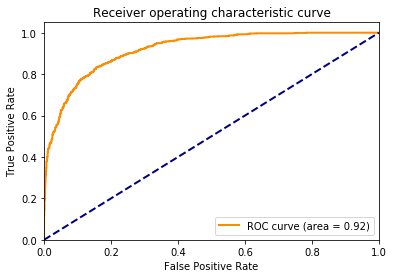

In [147]:
fig = roc_auc_curve(clf.best_estimator_, X_test, y_test)

In [148]:
fig.savefig("auc_roc.pdf", bbox_inches='tight')

In [149]:
from sklearn.inspection import plot_partial_dependence

In [150]:
fig_dependence = plt.figure()

<Figure size 432x288 with 0 Axes>

In [151]:
plot_partial_dependence(clf.best_estimator_, X, features=[0], feature_names=['number of insertions'], grid_resolution=100, fig=fig_dependence) 

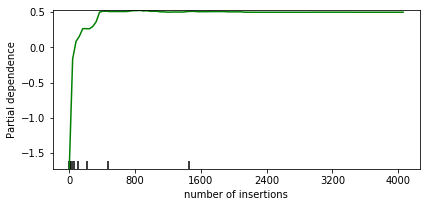

In [152]:
fig_dependence

## Evaluation on blamed commits

In [155]:
X_eval = eval_df.drop('label', axis=1)
y_eval = eval_df['label']
X_text_summary_eval = text_transformer.fit_transform(eval_df.summary.to_numpy(), y_eval)
X_text_description_eval = text_transformer.fit_transform(eval_df.description.to_numpy(), y_eval)
# preprocess X
X_eval = preprocessor.fit_transform(X_eval, y_eval)
X_categorical_eval = multi_value_target_encoding(eval_df, categorical_features, 'label', ';')
X_eval = np.hstack((X_eval,X_categorical_eval,X_text_summary_eval, X_text_description_eval))

In [156]:
clf.best_estimator_.score(X_eval, [1]*179)

0.7374301675977654

## Cross-validation

In [158]:
cv_results = cross_validate(clf.best_estimator_, X, y, scoring='accuracy', cv=StratifiedKFold(n_splits=10, shuffle=True))

In [159]:
cv_results

{'fit_time': array([11.30826902, 11.70612025, 11.4796412 , 11.59635496, 11.55467176,
        10.8740871 , 11.00135684, 11.1822319 , 11.09906101, 11.140306  ]),
 'score_time': array([0.00681114, 0.00716186, 0.00719595, 0.00697398, 0.00654221,
        0.00683308, 0.00710821, 0.00737095, 0.00654793, 0.00655293]),
 'test_score': array([0.76783005, 0.75417299, 0.75872534, 0.75341426, 0.77389985,
        0.76479514, 0.78376328, 0.7723824 , 0.78056188, 0.79483283])}

In [160]:
np.mean(cv_results['test_score'])

0.7704378017857787